In [1]:
import keras
print(keras.__version__)

2024-09-26 19:16:06.312079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 19:16:06.313857: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 19:16:06.386363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 19:16:06.753910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 19:16:08.805307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TR

3.3.3.dev2024062103


In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def conical_surface(eccentricity, num_points=100):
    if eccentricity < 0:
        raise ValueError("Eccentricity must be non-negative.")
    
    t = np.linspace(-np.pi, np.pi, num_points)
    a =1.0
    if eccentricity < 1:  # Ellipse
        b = a * np.sqrt(1 - eccentricity**2)
        x = a * np.cos(t)
        y = b * np.sin(t)
    elif eccentricity == 1:  # Parabola
        x = 2 * a * t
        y = t**2 
    else:  # Hyperbola
        b = a * np.sqrt(eccentricity**2 - 1)
        y = a * np.cosh(t)
        x = b * np.sinh(t)
    
    return x, y

In [4]:
e=1.1
x,y = conical_surface(e,1000)

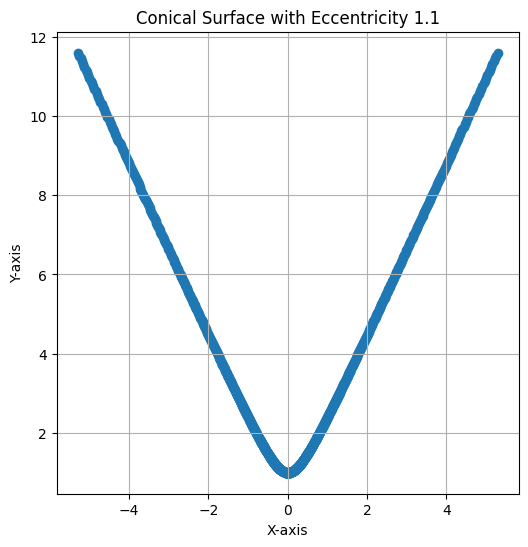

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Conical Surface with Eccentricity {e}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [6]:
def generate_elipses(e,a=1,num_points=100):
    t = np.linspace(-np.pi, np.pi, num_points)
    
    b = a * np.sqrt(1 - e**2)
    x = a * np.cos(t)
    y = b * np.sin(t)
    return x,y

In [7]:
def apply_rotation_translation(x,y,xt=0,yt=0,angle_rad=0):
    xf = xt + x * np.cos(angle_rad) - y * np.sin(angle_rad)
    yf = yt + x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return xf,yf

[]

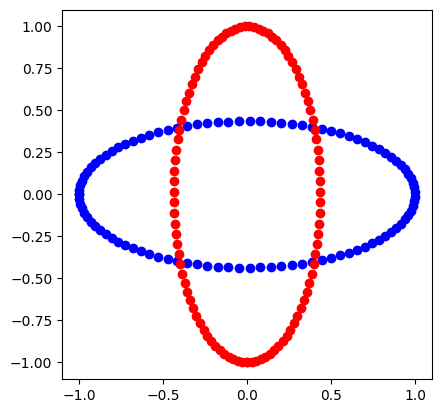

In [8]:
testex,testey=generate_elipses(0.9,1,100)
tx,ty=apply_rotation_translation(testex,testey,0,0,np.pi/2)
plt.scatter(testex,testey,color="blue")
plt.scatter(tx,ty,color="red")
plt.gca().set_aspect('equal', adjustable='box')

plt.plot()

In [9]:
import random
x_values = []
y_values = []
samples=10000*100
num_points=100
e_values=np.random.rand(samples)
a_values=100*np.random.rand(int(samples))

angle_values=0*np.pi*np.random.rand(samples)#2*np.pi*np.random.rand(samples)
xt_values=0*100*np.random.rand(samples)
yt_values=0*100*np.random.rand(samples)

for e,a,angle,xt,yt in zip(e_values,a_values,angle_values,xt_values,yt_values):
    x,y=generate_elipses(e,a,num_points)
    xf,yf=apply_rotation_translation(x,y,xt,yt,angle)
    x_values.append(xf)  # Append x values to list
    y_values.append(yf)  # Append y values to list



In [10]:
#lets add noise
x_noise=[]
y_noise=[]
for a,x in zip(a_values,x_values):
    noisex= np.random.normal(loc=0,scale=np.sqrt(a)*0,size=num_points)
    x_noise.append(noisex+x)
for a,y in zip(a_values,y_values):
    noisey= np.random.normal(loc=0,scale=np.sqrt(a)*0,size=num_points)
    y_noise.append(noisey+y)

#x_noise=x_values+a_values*noisex
#y_noise=y_values*a_values*noisey


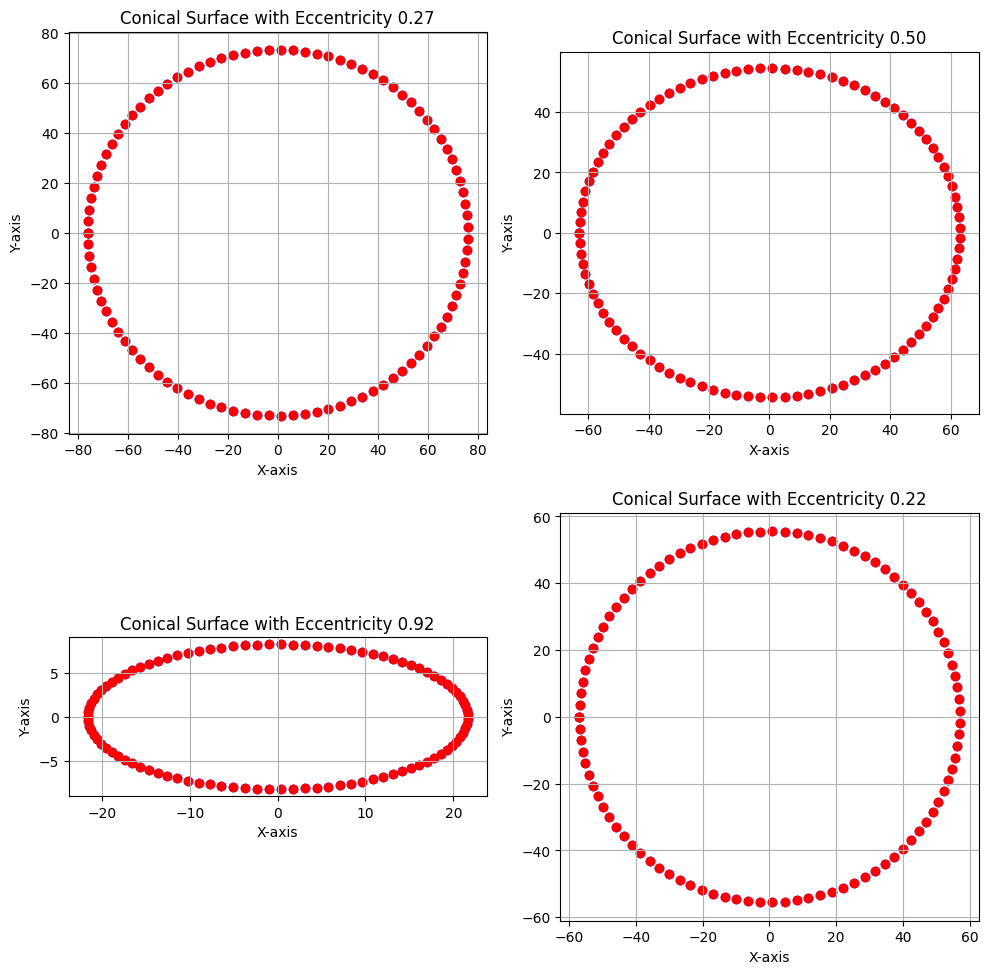

In [11]:
num_plots = 4
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Randomly choose 4 indices to plot
indices_to_plot = np.random.choice(samples, 4, replace=False)

# Plotting each subplot
for i, idx in enumerate(indices_to_plot):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    axs[row, col].scatter(x_values[idx], y_values[idx],color='blue')
    axs[row, col].scatter(x_noise[idx], y_noise[idx],color='red')

    axs[row, col].set_aspect('equal', adjustable='box')
    axs[row, col].set_title(f'Conical Surface with Eccentricity {e_values[idx]:.2f}')
    axs[row, col].set_xlabel('X-axis')
    axs[row, col].set_ylabel('Y-axis')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [12]:
#rede neural
#import tensorflow as tf
#from tensorflow import keras
from keras import models,layers,initializers

In [13]:
#input_data = [(x_noise[i], y_noise[i]) for i in range(len(x_noise))]
#input_data_flat = input_data.reshape((input_data.shape[0], -1))
input_data = np.concatenate([x_noise,y_noise],1)
output_data = np.column_stack([e_values,a_values])
print(input_data.shape)
print(e_values.shape)
print(output_data.shape)
print(len(input_data[0]))



(1000000, 200)
(1000000,)
(1000000, 2)
200


In [14]:
def prepare_data(x,y):
    return np.concatenate([x_noise,y_noise],1)

In [15]:
# Criar o modelo sequencial
model = models.Sequential(name="my_neural")
model.add(layers.Input(shape=(2 * num_points,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(1000, activation="tanh", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(2000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(200, activation="linear"))  # Saída com duas unidades, uma para 'a' e outra para 'e'

model.compile(optimizer="adam",loss="mse",metrics=["mean_squared_error"])

model.summary()


Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │       402,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2000)           │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │       400,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,826,000 (18.41 MB)

 Trainable params: 4,815,600 (18.37 MB)

 Non-trainable params: 10,400 (40.62 KB)

In [16]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_data,output_data,random_state=42,test_size=0.5)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train,x_train,epochs=100,batch_size=100,validation_data=(x_test,x_test),callbacks=[early_stopping])

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 489s 97ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 306s 61ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 334s 67ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 324s 65ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 291s 58ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 9.7735e-04 - val_mean_squared_error: 9.7735e-04
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 322s 64ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 320s 64ms/step - loss: 0.

In [18]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

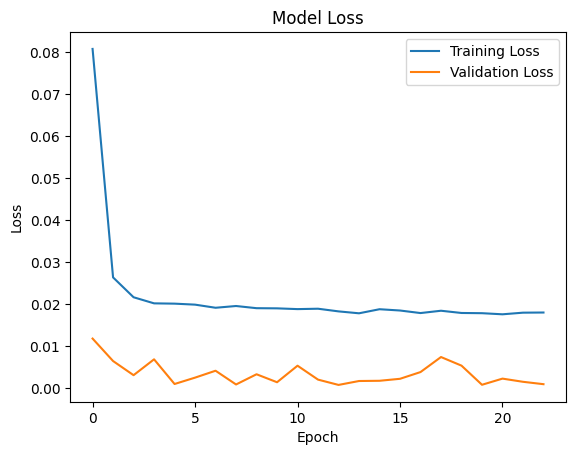

In [19]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
e=0
a=0.001

x_teste,y_teste = generate_elipses(e,a,100)
teste=np.concatenate([x_teste,y_teste])
# Reshape teste to match the expected input shape of your model
teste = np.expand_dims(teste, axis=0)  # Shape will be (1, 200)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


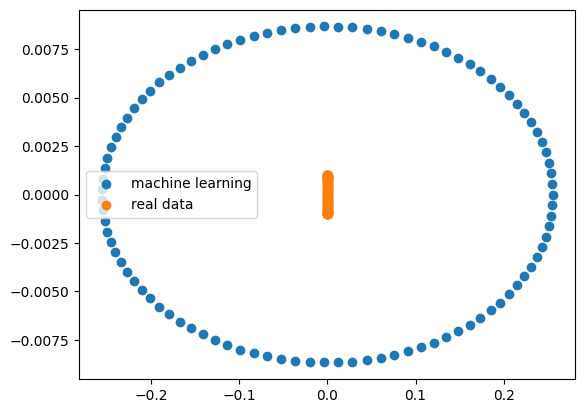

In [53]:
#vamos fixar as primeiras camadas:
t=model.predict(scaler.transform(teste))
t=scaler.inverse_transform(t)
teste2=scaler.inverse_transform(scaler.transform(teste))

plt.scatter(t[0][0:99],t[0][100:199],label="machine learning")
plt.scatter(teste2[0][0:99],teste2[0][100:199],label="real data")
plt.legend()